# Challenge summary statistics

In [25]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine

%matplotlib inline

disk_engine = create_engine('sqlite:///data/challenge_2016.sqlite3')

## Final rankings

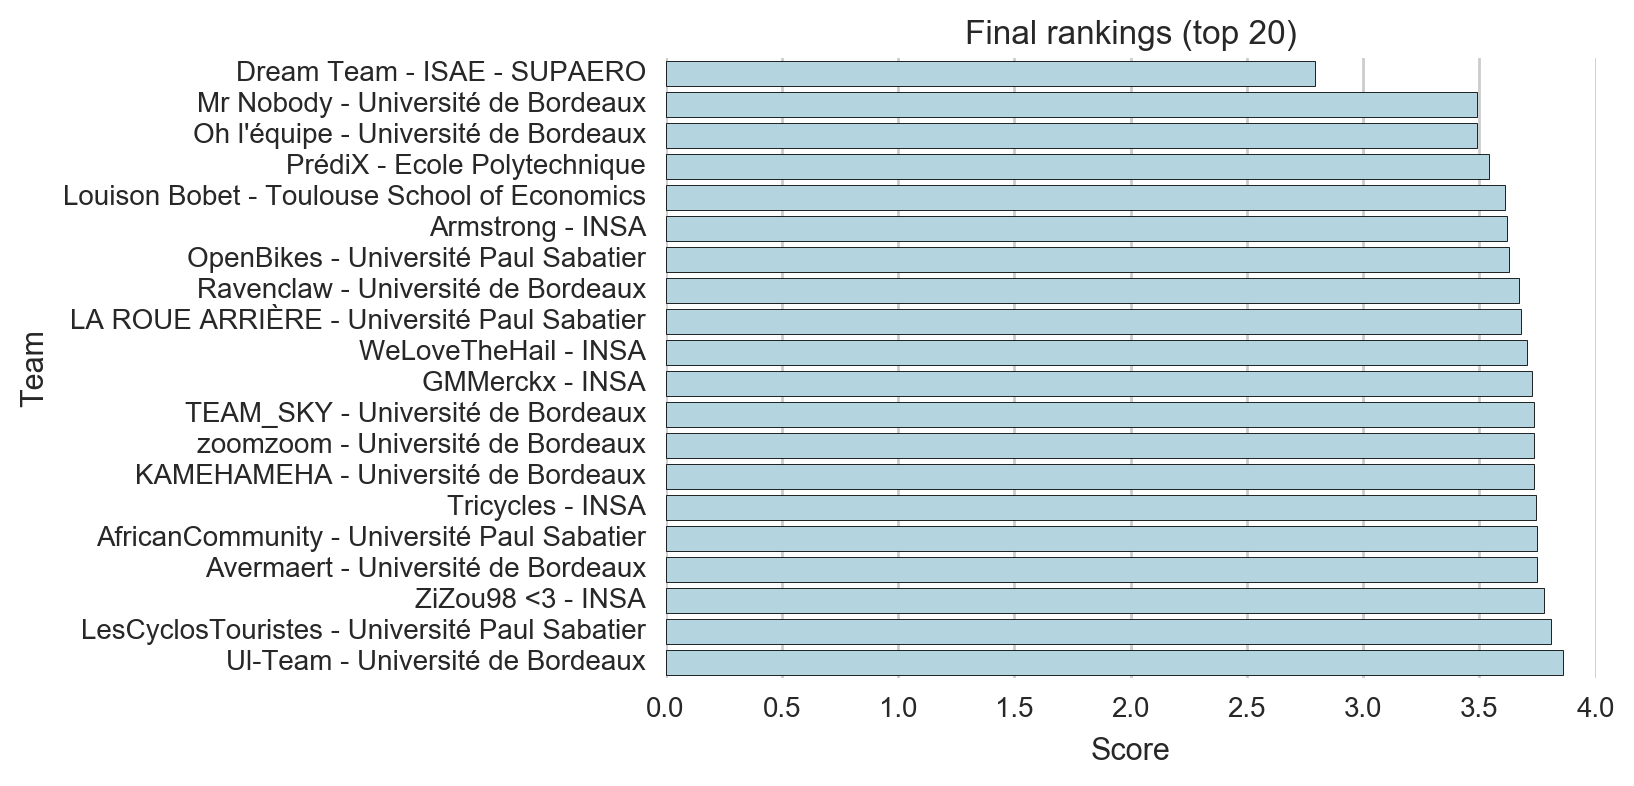

In [26]:
df = pd.read_sql_query(
    '''
    SELECT
        t.name as name,
        c.school as school,
        MIN(s.score) as best_score
    FROM
        persons p,
        submissions s,
        teams t,
        curriculums c
    WHERE
        p.team_id = t.id AND
        c.id = t.curriculum_id AND
        s.by_id = p.id AND
        s.valid = 1
    GROUP BY
        t.id
    ORDER BY
        best_score
    LIMIT 20
    ''',
    disk_engine
)

df['fullname'] = df['name'] + ' - ' + df['school']

sns.set_style('whitegrid')

fig, ax = plt.subplots()

sns.barplot(
    x='best_score',
    y='fullname',
    data=df,
    ax=ax,
    color='lightblue'
)

ax.set_xlabel('Score')
ax.set_ylabel('Team')
ax.set_title('Final rankings (top 20)')

sns.despine(left=True, bottom=True)

## Score and number of submissions

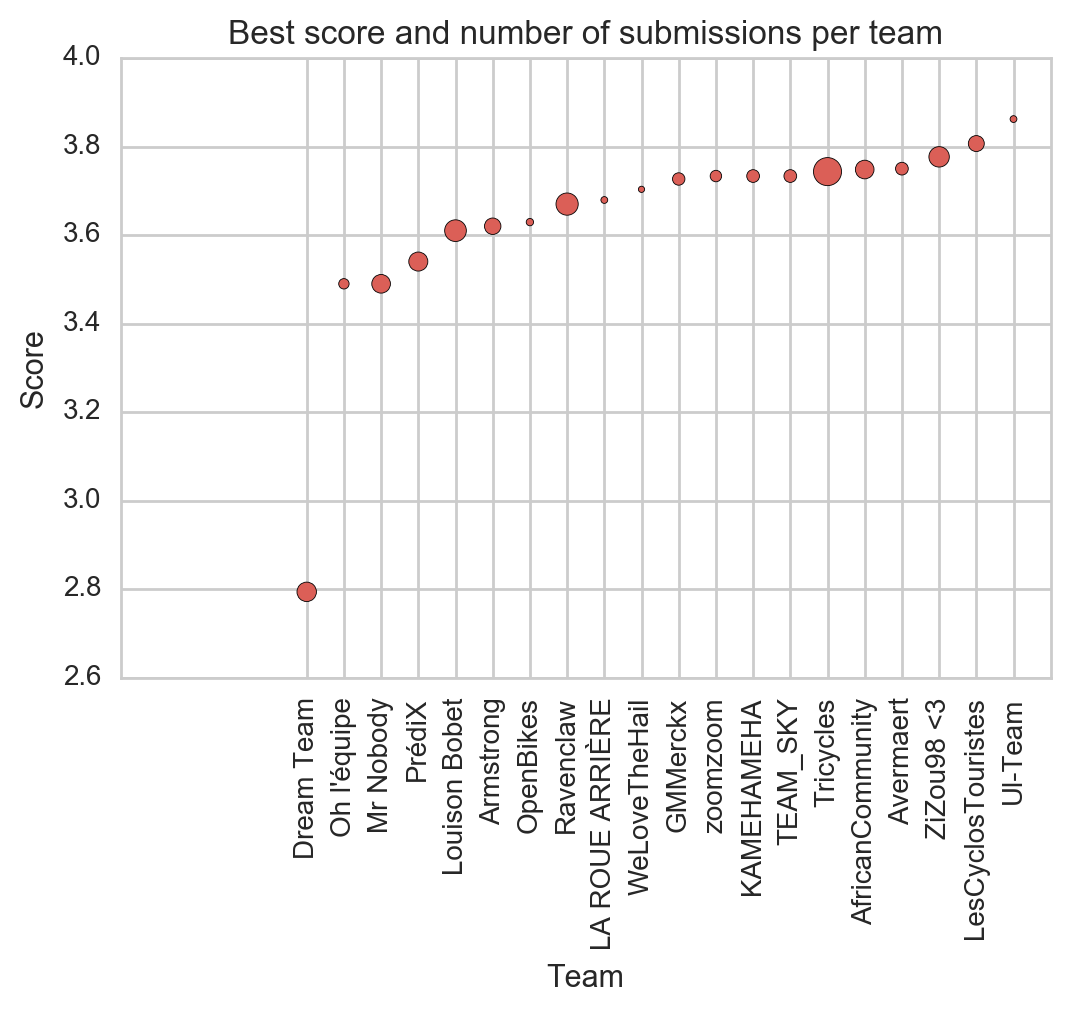

In [27]:
df = pd.read_sql_query(
    '''
    SELECT
        t.name as name,
        MIN(s.score) as best_score,
        COUNT(s.id) as n_submissions
    FROM
        persons p,
        submissions s,
        teams t
    WHERE
        p.team_id = t.id AND
        s.by_id = p.id AND
        s.valid = 1
    GROUP BY
        t.id
    ORDER BY
        best_score
    LIMIT 20
    ''',
    disk_engine
)

fig, ax = plt.subplots()

df.sort_values('best_score', ascending=False, inplace=True)
df['id'] = df.index

df.plot(
    x='id',
    y='best_score',
    s=df['n_submissions'],
    ax=ax,
    kind='scatter'
)

ax.set_xticks(list(reversed(list(range(len(df))))))
ax.set_xticklabels(df['name'].tolist(), rotation='vertical')
ax.set_xlabel('Team')
ax.set_ylabel('Score')
ax.set_title('Best score and number of submissions per team')

## Progressive minimum score per team

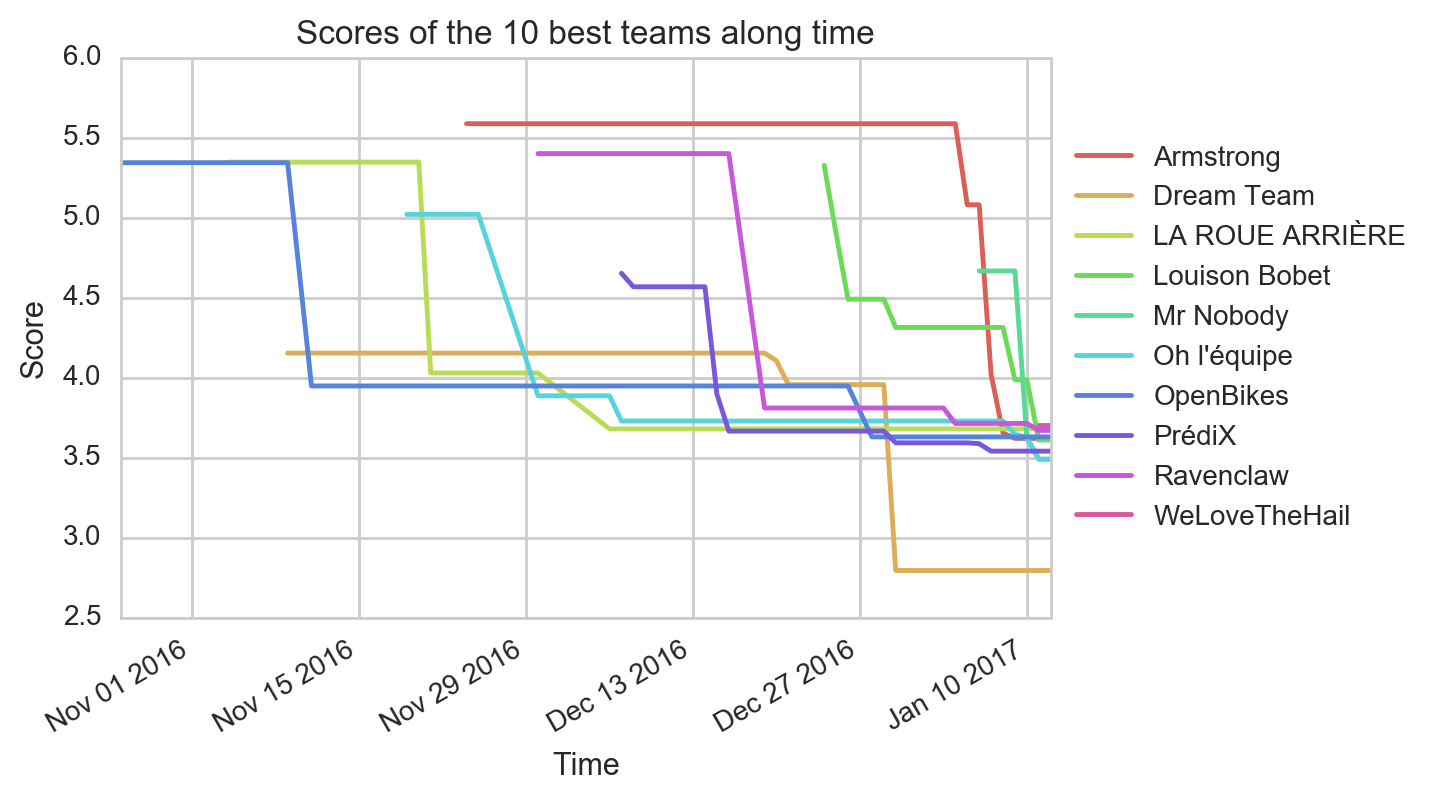

In [28]:
df = pd.read_sql_query(
    '''
    SELECT
        strftime('%Y-%m-%d', s.at) AS date, s.score, t.name
    FROM
        submissions s, teams t
    WHERE
        s.team_id = t.id AND
        s.valid = 1 AND
        s.score < 6 AND
        t.name IN (
            SELECT t.name
            FROM submissions s, teams t
            WHERE s.team_id = t.id
            GROUP BY t.name
            ORDER BY MIN(s.score)
            LIMIT 10
        )
    ''',
    disk_engine
)

# Parse date strings into datetime instances
df['date'] = df['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

tb = pd.pivot_table(
    data=df,
    values='score',
    index='date',
    columns='name',
    aggfunc=np.min,
    fill_value=np.inf
)

def fill_progressive_min(array):
    for i, v in enumerate(array):
        array[i] = min(array[:i+1])
    return array
    
for col in tb.columns:
    tb[col] = fill_progressive_min(tb[col])
    
sns.set_style('whitegrid')
sns.set_palette('hls', 10)

fig, ax = plt.subplots()

for team, scores in tb.iteritems():
    scores.replace(np.inf, np.nan).dropna().plot(ax=ax, label=team)
    
ax.set_xlabel('Time')
ax.set_ylabel('Score')
ax.set_title('Scores of the 10 best teams along time')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))